In [67]:
import numpy as np
import nltk
import pandas as pd
from pathlib import Path

from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk import FreqDist
from collections import Counter

# Import our model and the project's functions
from model.hmm import HMM
from main import get_data, per_tag_accuracy, accuracy as hmm_accuracy

FIG_DIR = Path("tex_files/figuras")
FIG_DIR.mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt

def save_fig(name):
    """Save current matplotlib figure to FIG_DIR with tight layout."""
    plt.tight_layout()
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches='tight')


The function below:

- Loads the UD Basque train, development, and test CSV files
- Converts each row into aligned (word, tag) pairs using load_ud_csv 
- Ensures that every word has a corresponding POS tag
- Extracts sentence and tag sequences using get_data
- Stores the processed data for train, dev, and test splits
- Prints the number of sentences in each dataset

In [112]:
def load_ud_csv(path):
    df = pd.read_csv(path, encoding="latin1")
    sentences = []
    for _, row in df.iterrows():
        words = row["text"].split()
        tags = row["tags"].split()
        assert len(words) == len(tags)
        sentences.append(list(zip(words, tags)))
    return sentences

In [113]:
# Data loading: Basque
train_sentences, train_tags = get_data("datasets/ud_basque/ud_basque_train.csv")
dev_sentences,   dev_tags   = get_data("datasets/ud_basque/ud_basque_dev.csv")
test_sentences,  test_tags  = get_data("datasets/ud_basque/ud_basque_test.csv")

print(f"# sentences in train: {len(train_sentences)}")
print(f"# sentences in dev:   {len(dev_sentences)}")
print(f"# sentences in test:  {len(test_sentences)}")

# sentences in train: 5396
# sentences in dev:   1798
# sentences in test:  1799


In [114]:
print("Example sentence from the train set:")
print(train_sentences[0])

Example sentence from the train set:
['Gero', ',', 'lortutako', 'masa', 'molde', 'batean', 'jarri', '.']


Here we compute the frequency of each POS tag in the training set of Basque.
This is directly related to the theory discussed in class:

- HMMs estimate transition and emission probabilities from tag frequencies
- Frequent tags contribute more to probability estimates
- Rare tags are more affected by data sparsity

The plotted distribution helps visualize which tags dominate the corpus and anticipate challenges during training.

Tags found: {'ADJ', 'AUX', 'PUNCT', 'VERB', 'CCONJ', 'SCONJ', 'NUM', 'X', 'PRON', 'PROPN', 'SYM', 'NOUN', 'ADP', 'PART', 'ADV', 'INTJ', 'DET'}
Total number: 17


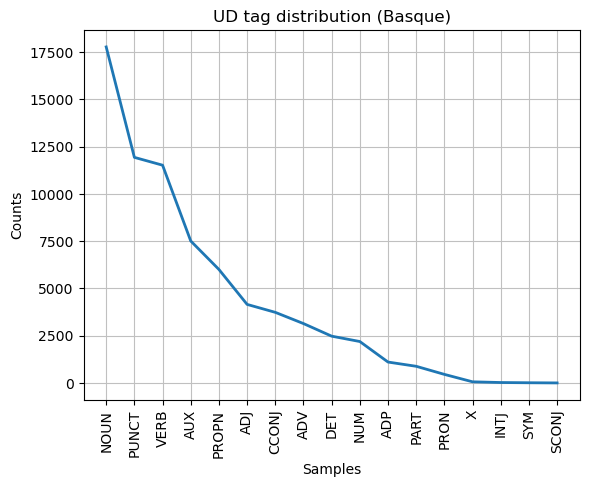

<Axes: title={'center': 'UD tag distribution (Basque)'}, xlabel='Samples', ylabel='Counts'>

In [115]:

all_tags = [tag for sent in train_tags for tag in sent]
tagset = set(all_tags)
print("Tags found:", tagset)
print("Total number:", len(tagset))

freq = FreqDist(all_tags)
freq.plot(30, title="UD tag distribution (Basque)")


The function below:

- Loads the UD Catalan train, development, and test CSV files
- Converts each row into aligned (word, tag) pairs using load_ud_csv 
- Ensures that every word has a corresponding POS tag
- Extracts sentence and tag sequences using get_data
- Stores the processed data for train, dev, and test splits
- Prints the number of sentences in each dataset

In [116]:
# Data loading: Catalan
train_sentences_ca, train_tags_ca = get_data("datasets/ud_catalan/ud_catalan_train.csv")
dev_sentences_ca,   dev_tags_ca   = get_data("datasets/ud_catalan/ud_catalan_dev.csv")
test_sentences_ca,  test_tags_ca  = get_data("datasets/ud_catalan/ud_catalan_test.csv")

print(f"# [CAT] sentences in train: {len(train_sentences_ca)}")
print(f"# [CAT] sentences in dev:   {len(dev_sentences_ca)}")
print(f"# [CAT] sentences in test:  {len(test_sentences_ca)}")


# [CAT] sentences in train: 13123
# [CAT] sentences in dev:   1709
# [CAT] sentences in test:  1846


Here we compute the frequency of each POS tag in the training set of Catalan.

Tags found (CAT): {'AUX', 'ADJ', 'PUNCT', 'VERB', 'CCONJ', 'INTJ', 'NUM', 'PRON', 'ADV', 'SYM', 'NOUN', 'ADP', 'PART', 'PROPN', 'SCONJ', 'DET'}
Total number (CAT): 16


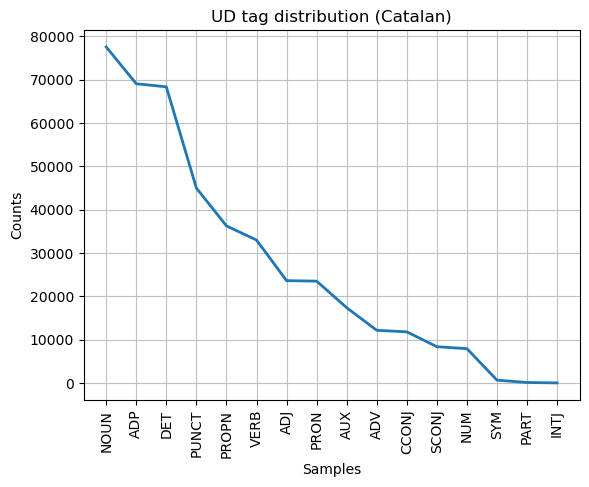

<Axes: title={'center': 'UD tag distribution (Catalan)'}, xlabel='Samples', ylabel='Counts'>

In [117]:
# Tag distribution for Catalan
all_tags_ca = [tag for sent in train_tags_ca for tag in sent]
tagset_ca = set(all_tags_ca)
print("Tags found (CAT):", tagset_ca)
print("Total number (CAT):", len(tagset_ca))

freq_ca = FreqDist(all_tags_ca)
freq_ca.plot(30, title="UD tag distribution (Catalan)")



## Hidden Markov Models for POS Tagging (Basque & Catalan)

This section trains two different HMM-based POS taggers for Basque and Catalan:

- **NLTK’s HiddenMarkovModelTagger**, which requires each sentence to be a list of `(word, tag)` pairs  
- **Our custom HMM implementation**, which takes `train_sentences` (lists of words) and `train_tags` (lists of POS tags)

---

### Data Preparation

NLTK expects labeled sequences in the form:

\[
[(w_1, t_1), (w_2, t_2), \ldots, (w_n, t_n)]
\]

Therefore, we rebuild:

- `labeled_train_eu` from `train_sentences` and `train_tags`
- `labeled_train_ca` from `train_sentences_ca` and `train_tags_ca`

NLTK then estimates:

- **Transition probabilities**
  \[
  P(y_i \mid y_{i-1})
  \]

- **Emission probabilities**
  \[
  P(x_i \mid y_i)
  \]

- **Initial probabilities**, extracted from sentence-initial tags

---

### Our Custom HMM

Our own HMM uses the classical generative model:

\[
P(X, Y) = P(y_1) 
\prod_{i=2}^{n} P(y_i \mid y_{i-1})
\prod_{i=1}^{n} P(x_i \mid y_i)
\]

Training proceeds in two steps:

**1. Counting**

- tag-to-tag transitions  
- tag-to-word emissions  
- sentence starts via a special token `*`  
- `STOP` transitions  
- vocabulary and tag counts  

**2. Maximum Likelihood Estimation (MLE)**

Transition probabilities:

\[
P(y_i \mid y_{i-1}) = 
\frac{\text{count}(y_{i-1} \rightarrow y_i)}
     {\sum_{y'} \text{count}(y_{i-1} \rightarrow y')}
\]

Emission probabilities:

\[
P(x_i \mid y_i) = 
\frac{\text{count}(y_i \rightarrow x_i)}
     {\sum_{x'} \text{count}(y_i \rightarrow x')}
\]

---

### Decoding with Viterbi

To predict tags, both the Basque and Catalan models use our Viterbi implementation.

**Initialization**

\[
V_1(y) = P(y \mid *) \cdot P(x_1 \mid y)
\]

**Recursion**

\[
V_t(y) = 
\left[
\max_{y'} \, V_{t-1}(y') \cdot P(y \mid y')
\right]
\cdot P(x_t \mid y)
\]

**Termination**

\[
V_n(y) \cdot P(\text{STOP} \mid y)
\]

**Backtracking** recovers the most probable tag sequence.





In [118]:
# Build labeled sequences for Basque
labeled_train_eu = [list(zip(words, tags)) for words, tags in zip(train_sentences,    train_tags)]
labeled_dev_eu   = [list(zip(words, tags)) for words, tags in zip(dev_sentences,      dev_tags)]
labeled_test_eu  = [list(zip(words, tags)) for words, tags in zip(test_sentences,     test_tags)]

# Build labeled sequences for Catalan
labeled_train_ca = [list(zip(words, tags)) for words, tags in zip(train_sentences_ca, train_tags_ca)]
labeled_dev_ca   = [list(zip(words, tags)) for words, tags in zip(dev_sentences_ca,   dev_tags_ca)]
labeled_test_ca  = [list(zip(words, tags)) for words, tags in zip(test_sentences_ca,  test_tags_ca)]


# HMM (NLTK) for Basque
tagger_eu = HiddenMarkovModelTagger.train(labeled_train_eu)

# HMM (NLTK) for Catalan
tagger_ca = HiddenMarkovModelTagger.train(labeled_train_ca)


# Our HMM for Basque
hmm_eu = HMM()
hmm_eu.train(train_sentences=train_sentences, train_tags=train_tags)

# Our HMM for Catalan
hmm_ca = HMM()
hmm_ca.train(train_sentences=train_sentences_ca, train_tags=train_tags_ca)


We evaluate the model using **token-level accuracy**, defined as:

\[
\text{accuracy} = 
\frac{\text{number of correctly predicted tags}}
{\text{total number of tags}}
\]

In [119]:
# ==== Accuracy of the NLTK HMM (Basque) ====
acc_train_nltk_eu = tagger_eu.accuracy(labeled_train_eu)
acc_dev_nltk_eu   = tagger_eu.accuracy(labeled_dev_eu)
acc_test_nltk_eu  = tagger_eu.accuracy(labeled_test_eu)

print(f"[NLTK HMM EU] Train accuracy: {acc_train_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Dev accuracy:   {acc_dev_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Test accuracy:  {acc_test_nltk_eu:.4f}")


# ==== Accuracy of the NLTK HMM (Catalan) ====
acc_train_nltk_ca = tagger_ca.accuracy(labeled_train_ca)
acc_dev_nltk_ca   = tagger_ca.accuracy(labeled_dev_ca)
acc_test_nltk_ca  = tagger_ca.accuracy(labeled_test_ca)

print(f"[NLTK HMM CA] Train accuracy: {acc_train_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Dev accuracy:   {acc_dev_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Test accuracy:  {acc_test_nltk_ca:.4f}")


# ==== Accuracy of our custom HMM (Basque) ====
acc_train_ours_eu = hmm_accuracy(hmm_eu, train_sentences, train_tags)
acc_dev_ours_eu   = hmm_accuracy(hmm_eu, dev_sentences,   dev_tags)
acc_test_ours_eu  = hmm_accuracy(hmm_eu, test_sentences,  test_tags)

print(f"[Our HMM EU] Train accuracy: {acc_train_ours_eu:.4f}")
print(f"[Our HMM EU]   Dev accuracy: {acc_dev_ours_eu:.4f}")
print(f"[Our HMM EU]  Test accuracy: {acc_test_ours_eu:.4f}")

# ==== Accuracy of our custom HMM (Catalan) ====
acc_train_ours_ca = hmm_accuracy(hmm_ca, train_sentences_ca, train_tags_ca)
acc_dev_ours_ca   = hmm_accuracy(hmm_ca, dev_sentences_ca,   dev_tags_ca)
acc_test_ours_ca  = hmm_accuracy(hmm_ca, test_sentences_ca,  test_tags_ca)

print(f"[Our HMM CA] Train accuracy: {acc_train_ours_ca:.4f}")
print(f"[Our HMM CA]   Dev accuracy: {acc_dev_ours_ca:.4f}")
print(f"[Our HMM CA]  Test accuracy: {acc_test_ours_ca:.4f}")



[NLTK HMM EU] Train accuracy: 0.9569
[NLTK HMM EU] Dev accuracy:   0.8258
[NLTK HMM EU] Test accuracy:  0.8189
[NLTK HMM CA] Train accuracy: 0.9703
[NLTK HMM CA] Dev accuracy:   0.9453
[NLTK HMM CA] Test accuracy:  0.9430
[Our HMM EU] Train accuracy: 0.9693
[Our HMM EU]   Dev accuracy: 0.8622
[Our HMM EU]  Test accuracy: 0.8560
[Our HMM CA] Train accuracy: 0.9759
[Our HMM CA]   Dev accuracy: 0.9475
[Our HMM CA]  Test accuracy: 0.9436


Now we compare de accuracies of the NLTK HMM and ours in both languages.

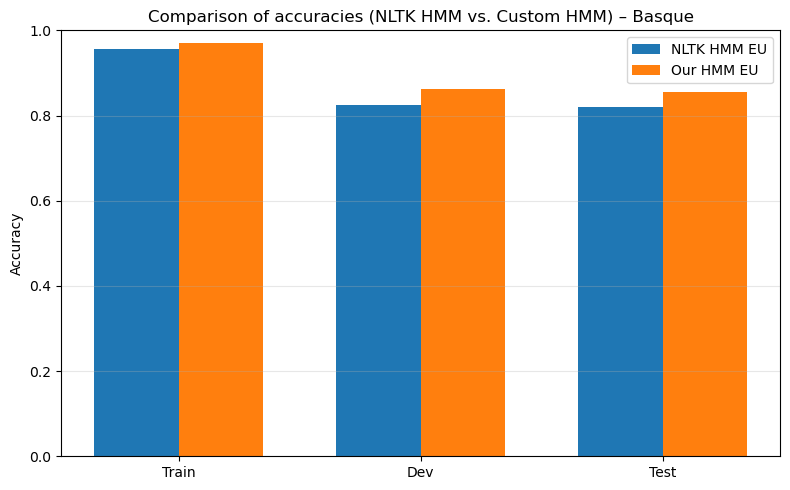

In [120]:
import matplotlib.pyplot as plt

models = ["Train", "Dev", "Test"]
nltk_acc_eu = [acc_train_nltk_eu, acc_dev_nltk_eu, acc_test_nltk_eu]
ours_acc_eu = [acc_train_ours_eu, acc_dev_ours_eu, acc_test_ours_eu]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_eu, width, label="NLTK HMM EU")
plt.bar(x + width/2, ours_acc_eu, width, label="Our HMM EU")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies (NLTK HMM vs. Custom HMM) – Basque")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()




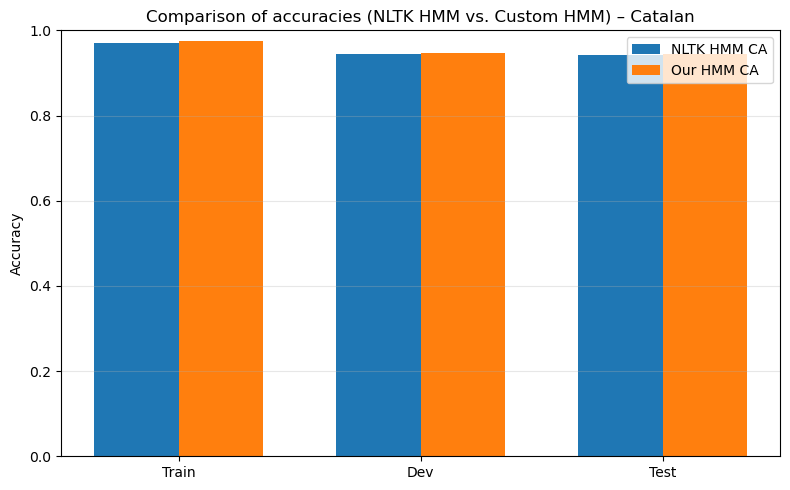

In [121]:
nltk_acc_ca = [acc_train_nltk_ca, acc_dev_nltk_ca, acc_test_nltk_ca]
ours_acc_ca = [acc_train_ours_ca, acc_dev_ours_ca, acc_test_ours_ca]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_ca, width, label="NLTK HMM CA")
plt.bar(x + width/2, ours_acc_ca, width, label="Our HMM CA")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies (NLTK HMM vs. Custom HMM) – Catalan")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()


Once trained, the HMM can assign POS tags to new sentences.  
It does so using the **Viterbi algorithm**, which finds the most probable tag sequence:

\[
Y^\* = \arg\max_Y P(X, Y)
\]

`tagger.best_path(sentence)` runs Viterbi internally and returns the optimal tag sequence.

In [122]:
# === Example EU ===
sentence_eu = "Gero , masa jarri molde batean .".split()

pred_nltk_eu  = tagger_eu.best_path(sentence_eu)
pred_ours_eu  = hmm_eu.viterbi(sentence_eu)

print("=== NLTK HMM (EU) ===")
print(list(zip(sentence_eu, pred_nltk_eu)))

print("=== Our HMM (EU) ===")
print(list(zip(sentence_eu, pred_ours_eu)))


=== NLTK HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]
=== Our HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]


In [123]:
# === Example CA ===
sentence_ca = "Després , la massa es posa en un motlle .".split()

pred_nltk_ca  = tagger_ca.best_path(sentence_ca)
pred_ours_ca  = hmm_ca.viterbi(sentence_ca)

print("=== NLTK HMM (CA) ===")
print(list(zip(sentence_ca, pred_nltk_ca)))

print("=== Our HMM (CA) ===")
print(list(zip(sentence_ca, pred_ours_ca)))


=== NLTK HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]
=== Our HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]


HMMs are generative models.  
They allow us to compute the joint probability of a specific word–tag sequence:

\[
P(X, Y)
\]

This combined likelihood is useful for:

- analysing how well a proposed tagging fits a sentence  
- comparing multiple candidate taggings  
- exploring the syntactic plausibility of sequences

The function `tagger.probability()` computes:

\[
P((x_1,y_1), \dots, (x_n,y_n))
\]

In [124]:
tagger = tagger_eu  # we are gonna use the hmm of basque for this example

sent = "Gero masa jarri .".split()
tags = ["ADV", "NOUN", "VERB", "PUNCT"]

comb = list(zip(sent, tags))
print("Probability (EU):", tagger.probability(comb))


Probability (EU): 4.2920479139869727e-13


Since an HMM models the full joint distribution \(P(X, Y)\), it can also *generate* new word–tag sequences by sampling from:

- the initial state distribution  
- the transition probabilities  
- the emission probabilities  

This produces synthetic sentences following the structure the model has learned.

Sampling illustrates how the HMM internally represents patterns in the data.

In [125]:
rng = np.random.default_rng()

sample = tagger_eu.random_sample(rng=rng, length=10)
print(sample)


[('arloetakoek', 'PROPN'), ('bat', 'NUM'), ('monoa', 'NOUN'), ('eta', 'CCONJ'), ('kilometroko', 'NOUN'), ('irabazteaz', 'NOUN'), ('du', 'AUX'), ('joanez', 'PUNCT'), ('edo', 'CCONJ'), ('Irlanda', 'PROPN')]


To compare the HMM with other POS-tagging strategies, we also implement several backoff n-gram taggers:

- **Default tagger:** assigns the same tag to every word  
- **Unigram tagger:** chooses the most frequent tag for each word  
- **Bigram tagger:** conditions on the previous tag  
- **Trigram tagger:** conditions on the previous two tags

If a trigram is unseen, the model *backs off* to the bigram model;  
if the bigram is unseen, it backs off to the unigram model;  
and finally to the default tagger.

This corresponds to the “Backoff Tagging & n-gram models” section of the theory.

We evaluate these taggers and compare their performance with the HMM.

In [127]:
# === N-gram taggers (Basque) ===
default_eu = nltk.DefaultTagger("NOUN")

uni_eu = nltk.UnigramTagger(labeled_train_eu, backoff=default_eu)
bi_eu  = nltk.BigramTagger(labeled_train_eu, backoff=uni_eu)
tri_eu = nltk.TrigramTagger(labeled_train_eu, backoff=bi_eu)

print("Unigram accuracy (EU):", uni_eu.accuracy(labeled_test_eu))
print("Bigram accuracy  (EU):", bi_eu.accuracy(labeled_test_eu))
print("Trigram accuracy (EU):", tri_eu.accuracy(labeled_test_eu))


# === N-gram taggers (Catalan) ===
default_ca = nltk.DefaultTagger("NOUN")

uni_ca = nltk.UnigramTagger(labeled_train_ca, backoff=default_ca)
bi_ca  = nltk.BigramTagger(labeled_train_ca, backoff=uni_ca)
tri_ca = nltk.TrigramTagger(labeled_train_ca, backoff=bi_ca)

print("Unigram accuracy (CA):", uni_ca.accuracy(labeled_test_ca))
print("Bigram accuracy  (CA):", bi_ca.accuracy(labeled_test_ca))
print("Trigram accuracy (CA):", tri_ca.accuracy(labeled_test_ca))


Unigram accuracy (EU): 0.8593993599737425
Bigram accuracy  (EU): 0.8662509231147945
Trigram accuracy (EU): 0.8655944859276278
Unigram accuracy (CA): 0.9207427461010812
Bigram accuracy  (CA): 0.9347107575279443
Trigram accuracy (CA): 0.9353086747828397


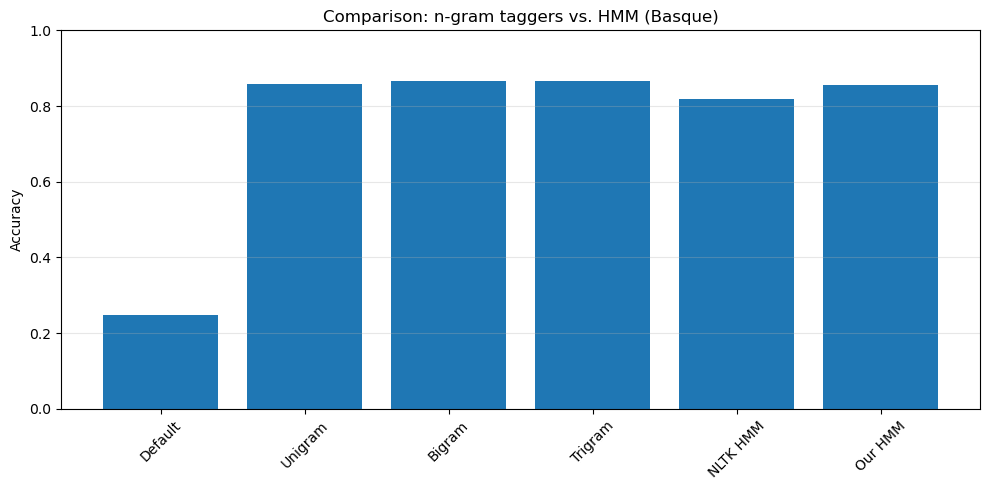

In [128]:
ngram_models = ["Default", "Unigram", "Bigram", "Trigram", "NLTK HMM", "Our HMM"]
ngram_acc = [
    default_eu.accuracy(labeled_test_eu),
    uni_eu.accuracy(labeled_test_eu),
    bi_eu.accuracy(labeled_test_eu),
    tri_eu.accuracy(labeled_test_eu),
    acc_test_nltk_eu,
    acc_test_ours_eu
]

plt.figure(figsize=(10,5))
plt.bar(ngram_models, ngram_acc)
plt.ylabel("Accuracy")
plt.title("Comparison: n-gram taggers vs. HMM (Basque)")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "ngram_vs_hmm_eu.png", dpi=300, bbox_inches="tight")
plt.show()


# Error distribution by tag

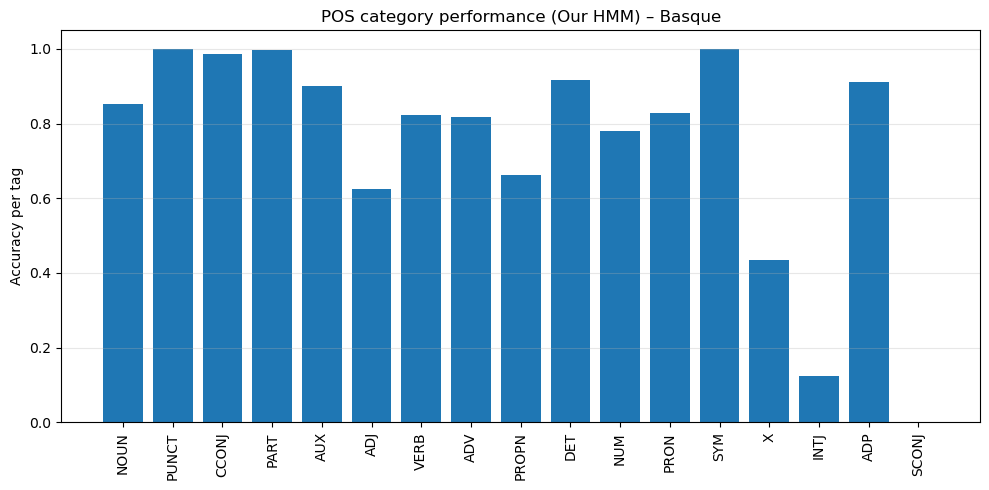

In [129]:
tag_acc_eu = per_tag_accuracy(hmm_eu, test_sentences, test_tags)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_eu.keys(), tag_acc_eu.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy per tag")
plt.title("POS category performance (Our HMM) – Basque")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()


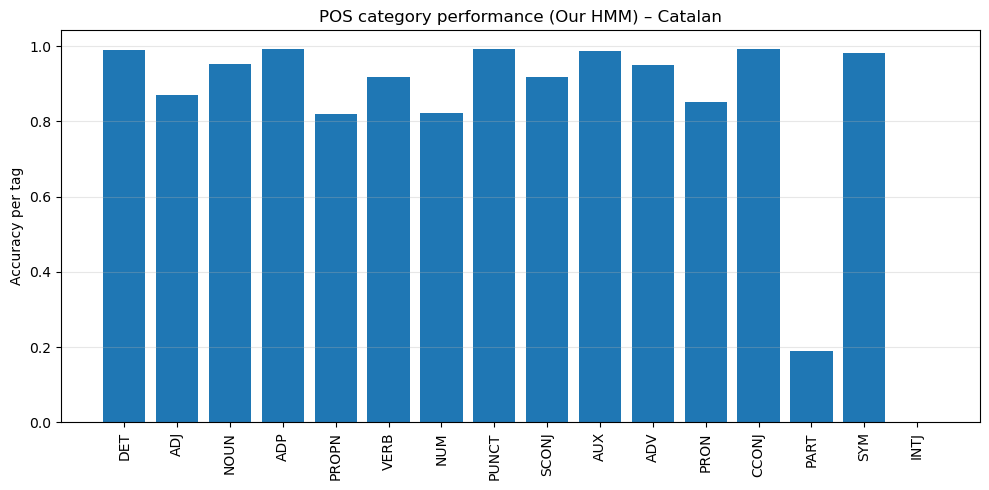

In [130]:
tag_acc_ca = per_tag_accuracy(hmm_ca, test_sentences_ca, test_tags_ca)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_ca.keys(), tag_acc_ca.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy per tag")
plt.title("POS category performance (Our HMM) – Catalan")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()
